# Ground State Search with Pauli Propagation
- DQA
- HVA 
- combined approach

for: 
- TFIM
- Heisenberg

## General functions

In [1]:
using PauliPropagation
using Plots
using Distributions: Uniform
using NLopt
using ReverseDiff: GradientTape, compile, gradient!

In [2]:
function adam_optimizer(thetas_init, lossfun, nq; eta=0.02, steps=150, refresh_grad_tape=50)
    tape = GradientTape(lossfun, thetas_init)
    compile(tape)
    grad = similar(thetas_init)
    thetas = copy(thetas_init)
    opt_energy = Float64[]

    m = zero(thetas)
    v = zero(thetas)
    β1, β2, ϵ = 0.9, 0.999, 1e-8

    for t in 1:steps

        if t%refresh_grad_tape == 0 # refresh the tape to avoid wrong gradients
                tape = GradientTape(lossfun, thetas)
                compile(tape)
        end
        gradient!(grad, tape, thetas)
        m .= β1 .* m .+ (1 - β1) .* grad
        v .= β2 .* v .+ (1 - β2) .* (grad .^ 2)
        m̂ = m ./ (1 - β1^t)
        v̂ = v ./ (1 - β2^t)
        thetas .-= eta .* m̂ ./ (sqrt.(v̂) .+ ϵ)
        push!(opt_energy, lossfun(thetas) / nq)
    end
    return thetas, opt_energy
end


adam_optimizer (generic function with 1 method)

In [3]:
function lbfgs_optimizer(thetas_init, lossfun, nq; max_iters=300, refresh_grad_tape=50)
    n = length(thetas_init)
    tape_ref = Ref(GradientTape(lossfun, thetas_init)) # Ref is only necessary in the LBFGS case because the closure otherwise can’t update an outer variable that NLopt is still using.
    compile(tape_ref[])
    gradbuf = zeros(n)
    iter_ref = Ref(0)
    opt = NLopt.Opt(:LD_LBFGS, n)
    NLopt.maxeval!(opt, max_iters)

    opt_energy = Float64[]
    NLopt.min_objective!(opt, (x, grad) -> begin

        iter_ref[] += 1
        # Re-record the tape every `refresh_grad_tape` evaluations.
        # Important: record with the current x so shapes/aliasing match.
        if refresh_grad_tape > 0 && (iter_ref[] % refresh_grad_tape == 0)
            tape_ref[] = GradientTape(lossfun, x)
            compile(tape_ref[])
        end

        fx = lossfun(x)::Float64
        if !isempty(grad)
            gradient!(gradbuf, tape_ref[], x)
            grad .= gradbuf
        end
        push!(opt_energy, fx)
        return fx
    end)
    minf, thetas, ret = NLopt.optimize(opt, thetas_init)
    return thetas, opt_energy ./ nq
end


lbfgs_optimizer (generic function with 1 method)

## TFIM Hamiltonian

In [4]:
function H_tfim(nq::Int; J::Float64=1.0, G::Float64=1.0, topology=nothing)
    H_tfim = PauliSum(nq)
    if topology == nothing
        topology = bricklayertopology(nq; periodic=false)
    end

    nbonds = length(topology)
    
    for qind in 1:nq
        add!(H_tfim, :X, qind, G)
    end

    for pair in topology
        add!(H_tfim, [:Z, :Z], collect(pair), J)
    end
    return H_tfim
end

H_tfim (generic function with 1 method)

### DQA - TFIM

In [5]:
function tfim_interpolation_circuit(nq, P; del_t= 0.1,J=1.0, G=1.0, hbar=1.0, topology=nothing)
    
    tau = del_t * P # tau is total annealing time, divided into P steps/layers of circuit
    if topology === nothing
        topology = bricklayertopology(nq; periodic=false)
    end

    circuit = tfitrottercircuit(nq, P; topology=topology, start_with_ZZ=false) # 1st order trotter
    #periodic ? nbonds = nq : nbonds = nq - 1 # if periodic nq bonds, else nq-1 (1d chain)
    nbonds = length(topology)
    total = P * (nq + nbonds)
    params  = Vector{Float64}(undef, total)
    idx = 1
    
    for m in 1:P # layers of trotterized circuit
        s_m = (m - 0.5) / P
        gamma_m = J* s_m * del_t /hbar # paper Eq. (12)
        beta_m = G*del_t*(2*s_m-1)/ hbar #(1-s_m) * del_t / hbar # paper Eq. (13a) - 1st order trotter
        theta_X = 2*beta_m            # angle for e^{-i theta_X X_j/2} - PauliRotation implementation in PP
        theta_ZZ = 2*gamma_m              # angle for e^{-i theta_ZZ Z_j Z_{j+1}/2}, J=1
        @inbounds fill!(view(params, idx:idx+nq-1), theta_X);             idx += nq # set X angles,then shift the index
        @inbounds fill!(view(params, idx:idx+nbonds-1), theta_ZZ);       idx += nbonds # set ZZ angles, then shift the index
    end
    return circuit, params
end

tfim_interpolation_circuit (generic function with 1 method)

In [6]:
# test full and stepwise interpolation run
nq = 4
P = 10000
G = 1.0
J = 1.0
hbar = 1.0
dt = 0.04


topology = bricklayertopology(nq; periodic=false)
H = H_tfim(nq; J=J, G=G, topology= topology)
nbonds = length(topology)

max_weight = 20
min_abs_coeff = 1e-8

circuit_full, params_full = tfim_interpolation_circuit(nq, P; del_t=dt, J=J, G=G, hbar=hbar, topology = topology)

# full propagation
propagated = propagate(circuit_full, H, params_full; max_weight, min_abs_coeff)
println(overlapwithplus(propagated)/nq)

# stepwise propagation
circuit_layer = tfitrottercircuit(nq, 1; topology=topology, start_with_ZZ=false) 
obs = deepcopy(H)
energy = []
for i in 1:P
    params_layer = params_full[(P-i)* (nq+nbonds)+1:(P-i+1)*(nq+nbonds)]
    psum = propagate!(circuit_layer, obs, params_layer, max_weight=max_weight, min_abs_coeff=min_abs_coeff)
    push!(energy, overlapwithplus(psum))
end
println(energy[end]/nq)

-1.1886763898892223
-1.1886763898892223


### HVA (with DQA) - TFIM

In [7]:
function HVA_loss_TFIM(thetas::AbstractVector, circuit, nq; J=1.0, G=1.0,
    topology=nothing, max_freq=Inf, max_weight=Inf)
    if isnothing(topology)
        topology = bricklayertopology(nq; periodic=false)
    end

    CoeffType = eltype(thetas)

    H = PauliSum(CoeffType, nq) 
   
    for pair in topology
        add!(H, [:Z, :Z], collect(pair), CoeffType(J))
    end
 
    for qind in 1:nq
        add!(H, :X, qind, CoeffType(G))
    end
    wrapped_H = wrapcoefficients(H, PauliFreqTracker)
    propagated = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight) 
    return overlapwithplus(propagated)
end

HVA_loss_TFIM (generic function with 1 method)

In [8]:
function run_HVA_TFIM(nq::Int=3; nl::Int=2, J=1.0, G=1.0, opt::Symbol=:adam, interpol_circ = nothing, verbose=true, max_freq=Inf, max_weight=Inf, steps=150, topology=nothing)
    circuit = tfitrottercircuit(nq, nl; topology=topology) # HVA circuit
    nparams = length(circuit)
    thetas_init = rand(Uniform(-0.1,0.1), nparams) # physically 0 is best, but stalls optimizer

    if interpol_circ!= nothing
        prepend!(circuit, interpol_circ)
    end

    # tie closure for differentiation
    closed_loss = let const_circ = circuit, const_nq = nq, const_J = J, const_G = G, const_max_freq=max_freq, const_max_weight=max_weight, const_topo = topology
        θ -> HVA_loss_TFIM(θ, const_circ, const_nq; J=const_J, G=const_G, max_freq=const_max_freq, max_weight=const_max_weight, topology=const_topo)
    end

    if opt == :adam
        thetas, E = adam_optimizer(thetas_init, closed_loss, nq; steps=steps)
    elseif opt == :lbfgs
        thetas, E = lbfgs_optimizer(thetas_init, closed_loss, nq; max_iters=steps)
    else
        error("Unknown optimizer $opt")
    end

    if verbose
        println("Final energy per qubit = $(E[end])")
        plot(E*nq, marker=:o, xlabel="Iteration", ylabel="Energy", title="DQA-HVA optimization ($opt)")
        # set x scale to log 
        
        display(current())
    end
    return thetas, E
end


run_HVA_TFIM (generic function with 2 methods)

Final energy per qubit = -1.189692620785908
-4.758770483143632


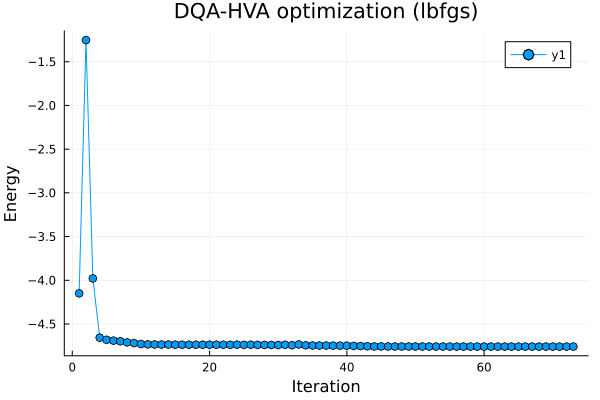

In [18]:
# test 
nq = 4
nl = 4
P = 100 
G = 1

# add truncations (min abs coeff is not available for variational optim)
max_weight = 20
max_freq = 200 # this is a small angle approximation (not our case!)
topology = bricklayertopology(nq; periodic=false) #open bc
interpol_circ, interpol_params = tfim_interpolation_circuit(nq, P; G=G, del_t=0.35)
interpol_circ = freeze(interpol_circ, interpol_params)
thetas, E = run_HVA_TFIM(nq; nl=nl, G=G, opt=:lbfgs, interpol_circ=interpol_circ, verbose=true, steps=500, topology=topology, max_freq=max_freq, max_weight=max_weight)
println(E[end]*nq)

Issues:
- We jump in energy (first step) due to parameter initialisation. We do come back to the correct approximate energy fast. Init params as 0 leads to the optimizer breaking.
- for nq odd, we converge to first excited state with DQA, HVA and the combined code. --> we can only use this for even nq.


## Heisenberg Hamiltonian

In [10]:
function overlapwithneel(operator, nq::Int; 
                           up_on_odd::Bool=true, 
                           params=nothing)
                           
    # Create Néel state bit representation: indices of "1" bits
    nb = neel_bits(nq; up_on_odd=up_on_odd)
    
    # Compute overlap with computational basis state
    return overlapwithcomputational(operator, nb)
end

overlapwithneel (generic function with 1 method)

In [11]:
function neel_bits(nq::Int; up_on_odd::Bool=true)
    if up_on_odd
        # |0101...> → "1" on even sites
        return collect(2:2:nq)
    else
        # |1010...> → "1" on odd sites
        return collect(1:2:nq)
    end
end

neel_bits (generic function with 1 method)

In [12]:
function H_heisenberg(nq::Int; J::Float64=1.0, topology=nothing)
    if topology === nothing
        topology = bricklayertopology(nq; periodic=false)
    end
    H_heis = PauliSum(nq)
    for (i,j) in topology
        add!(H_heis, [:X,:X], [i,j], J)
        add!(H_heis, [:Y,:Y], [i,j], J)
        add!(H_heis, [:Z,:Z], [i,j], J)
    end
    return H_heis
end 

H_heisenberg (generic function with 1 method)

### DQA - Heisenberg

In [13]:
function heisenberg_interpolation_circuit(nq, P; del_t= 0.1, J=1.0, hbar=1.0, topology=nothing) 
    tau = del_t * P # tau is total annealing time, divided into P steps/layers of circuit
    if topology === nothing
        topology = bricklayertopology(nq; periodic=false)
    end
    circuit = heisenbergtrottercircuit(nq, P;topology=topology)
    nbonds = length(topology)
    total = P * (3*nbonds)
    params  = Vector{Float64}(undef, total)
    idx = 1

    for m in 1:P # layers of trotterized circuit
        s_m = (m - 0.5) / P
        beta   = J * del_t / hbar    # ZZ coefficient
        gamma  =  J * s_m * del_t / hbar     # XX/YY coefficient
        θZZ = 2*beta
        θXX = 2*gamma
        θYY = 2*gamma
    
        @inbounds fill!(view(params, idx:idx+nbonds-1), θXX);             idx += nbonds
        @inbounds fill!(view(params, idx:idx+nbonds-1), θYY);             idx += nbonds
        @inbounds fill!(view(params, idx:idx+nbonds-1), θZZ);             idx += nbonds
    end
    
    return circuit, params
end

heisenberg_interpolation_circuit (generic function with 1 method)

In [14]:
# test (full propagation)
nq = 5
P= 10000
J=1.0 

topology = bricklayertopology(nq; periodic=false)
H_heis = H_heisenberg(nq; J=J, topology=topology)

max_weight = 20
min_abs_coeff = 1e-8

circuit_full, params_full = heisenberg_interpolation_circuit(nq, P; del_t=0.1, topology=topology)

propagated = propagate(circuit_full, H_heis, params_full; max_weight, min_abs_coeff)
println(overlapwithneel(propagated, nq)/nq)



-1.5307141568282696


### HVA (with DQA) - Heisenberg

In [15]:
function HVA_loss_Heisenberg(thetas::AbstractVector, circuit, nq; J= 1.0,
    topology=nothing, max_freq=Inf, max_weight=Inf)
    if isnothing(topology)
        topology = bricklayertopology(nq; periodic=false)
    end

    CoeffType = eltype(thetas)
    H = PauliSum(CoeffType, nq)
    for pair in topology
        add!(H, [:X, :X], collect(pair), CoeffType(J))
        add!(H, [:Y, :Y], collect(pair), CoeffType(J))
        add!(H, [:Z, :Z], collect(pair), CoeffType(J))
    end

    wrapped_H = wrapcoefficients(H, PauliFreqTracker)
    propagated = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight) 
    return overlapwithneel(propagated, nq)
end

HVA_loss_Heisenberg (generic function with 1 method)

In [16]:
function run_HVA_Heisenberg(nq::Int=3; nl::Int=2, opt::Symbol=:adam, interpol_circ=nothing, verbose=true, max_freq=Inf, max_weight=Inf, steps=150, topology = nothing)
    circuit = heisenbergtrottercircuit(nq, nl; topology= topology) # HVA circuit
    nparams = length(circuit)
    thetas_init = rand(Uniform(-0.1, 0.1), nparams)

    
    if interpol_circ!= nothing
        prepend!(circuit, interpol_circ)
    end
    
    # tie closure for differentiation
    closed_loss = let const_circ = circuit, const_nq = nq,const_J = J, const_max_freq=max_freq, const_max_weight=max_weight
        θ -> HVA_loss_Heisenberg(θ, const_circ, const_nq; J = const_J, max_freq=const_max_freq, max_weight=const_max_weight)
    end

    if opt == :adam
        thetas, E = adam_optimizer(thetas_init, closed_loss, nq; steps=steps)
    elseif opt == :lbfgs
        thetas, E = lbfgs_optimizer(thetas_init, closed_loss, nq)
    else
        error("Unknown optimizer $opt")
    end
    
    if verbose
        println("Final energy per qubit = $(E[end])")
        plot(E, marker=:o, xlabel="Iteration", ylabel="E/Q", title="HVA optimization ($opt)")
        display(current())
    end
    return thetas, E
end

run_HVA_Heisenberg (generic function with 2 methods)

Final energy per qubit = -1.5423090026543957


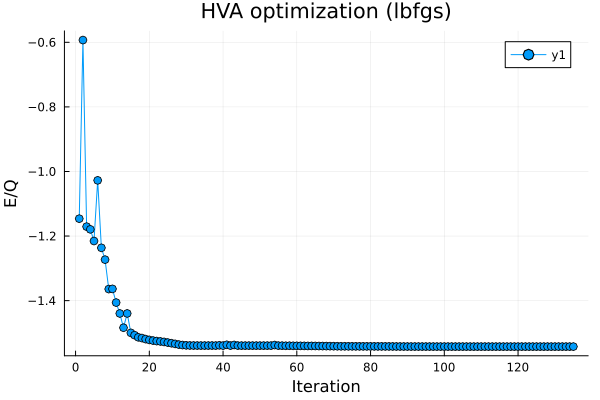

([0.11744180705838506, -0.23918625273527802, 0.01173300517475542, -0.5151392778318239, 0.2082866416942416, -0.8004622105383996, 0.01427426497458207, -0.3014875002954012, -0.039033400780345846, -0.6936611983335776  …  0.46439540734569057, -0.4417644552609941, -0.5894893647787113, 0.041884047538857015, 0.21205006182334665, -0.4307746124469456, 0.7899159271091318, -1.1324115275953992, -0.636791468035023, 0.8828411423423356], [-1.146169802191277, -0.5930458674077752, -1.170802473705384, -1.1792115146214595, -1.2152868766145382, -1.0274650729471493, -1.236432048835617, -1.273021849631694, -1.3641745952130298, -1.36358063437715  …  -1.5423090004679336, -1.542309002315955, -1.5423090025891109, -1.5423090026445236, -1.5423090026528663, -1.5423090026541193, -1.5423090026543707, -1.5423090026543913, -1.5423090026543955, -1.5423090026543957])

In [17]:
# test run
nq = 5 
nl = 3 # layers of HVA
P = 10 # steps for interpolation circuit to reach the target Hamiltonian
J = 1.0
max_weight = 20
max_freq  = 200

topology = bricklayertopology(nq; periodic=false) #open bc
interpol_circ, interpol_params = heisenberg_interpolation_circuit(nq,P)
interpol_circ = freeze(interpol_circ, interpol_params)
thetas, E = run_HVA_Heisenberg(nq; nl=nl, opt=:lbfgs, interpol_circ=interpol_circ, verbose=true, max_weight=max_weight, steps = 500, topology=topology, max_freq=max_freq)